In [4]:
import sys;import os;
module_path = os.path.abspath(os.path.join('..')).split('PythonCode')[0]+'PythonCode'
if module_path not in sys.path: sys.path.append(module_path+"/")
    
# Plib imports for the strategy
import Plib.Options.CalendarSpread as o
import Plib.Options.Models as opt
import Plib.DataFarm.Kibot as datafarm1
import Plib.DataFarm.Orats as datafarm2
import Plib.Plotting.Plots as pl1
import Plib.Volatility.Estimation as pl2
import Plib.Utils.Tools as tls
import Plib.DataFarm.FRData as fr

import warnings
warnings.filterwarnings("ignore")

import math as m
import pandas as pd
from IPython.display import clear_output

%matplotlib inline

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

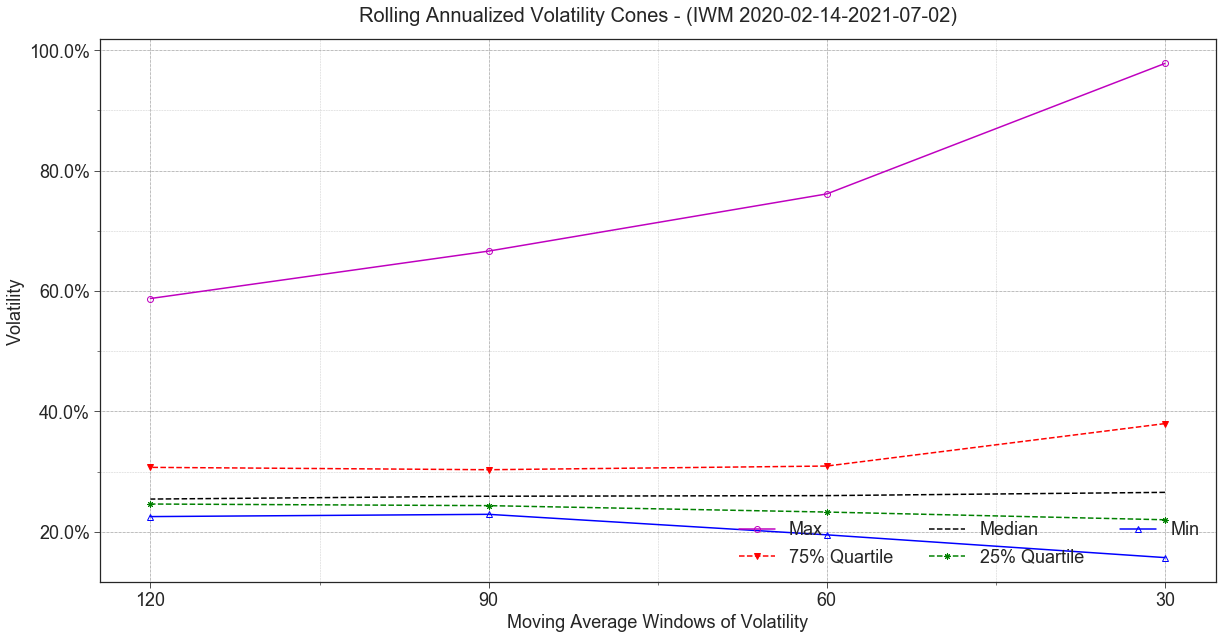

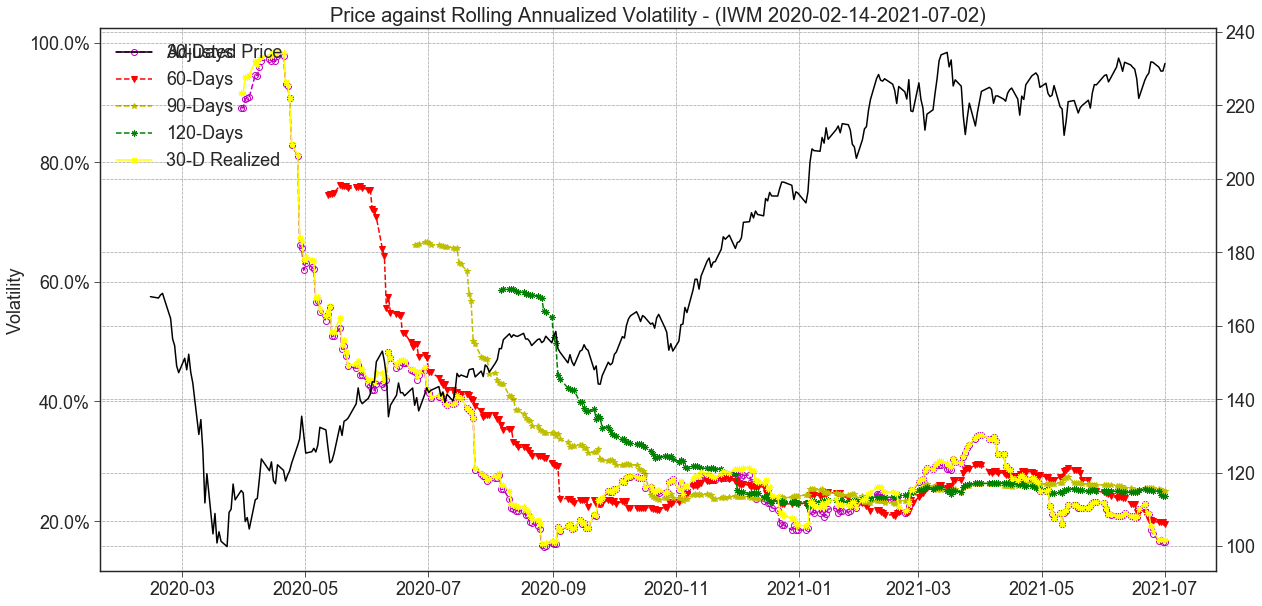

Current Price and Estimated std: 231.41 0.0573
Price Range in one standard deviation: 244.6698 218.1502


In [6]:
orats=True

symbol = 'IWM'

eval_data = '2021-07-02'
dt_start,dt_end=tls.getDates(offset=-(252*2),today_date=eval_data)

threshold=0.08
iRate=0.01
desc = symbol + " " + dt_start + "-" + eval_data

prices = pd.DataFrame(datafarm1.get_eod_data(symbol, dt_start, dt_end).interpolate())
cones, vols = pl2.volconesSV(prices)
#realized, roll30, roll, roll60, roll120
prange_sigma=m.sqrt(vols[0].mean()*100)/100
pl2.plotDiagCones(cones,vols,desc,prices,prange_sigma)

Underlying Price Measures
                     Values
Mean Price         175.5200
Median Price       162.5150
Daily Avg BB Range  29.2461
Monthly BB MA Mean 174.3485
Monthly 50 MA Mean 174.5001
Last Price         231.4100


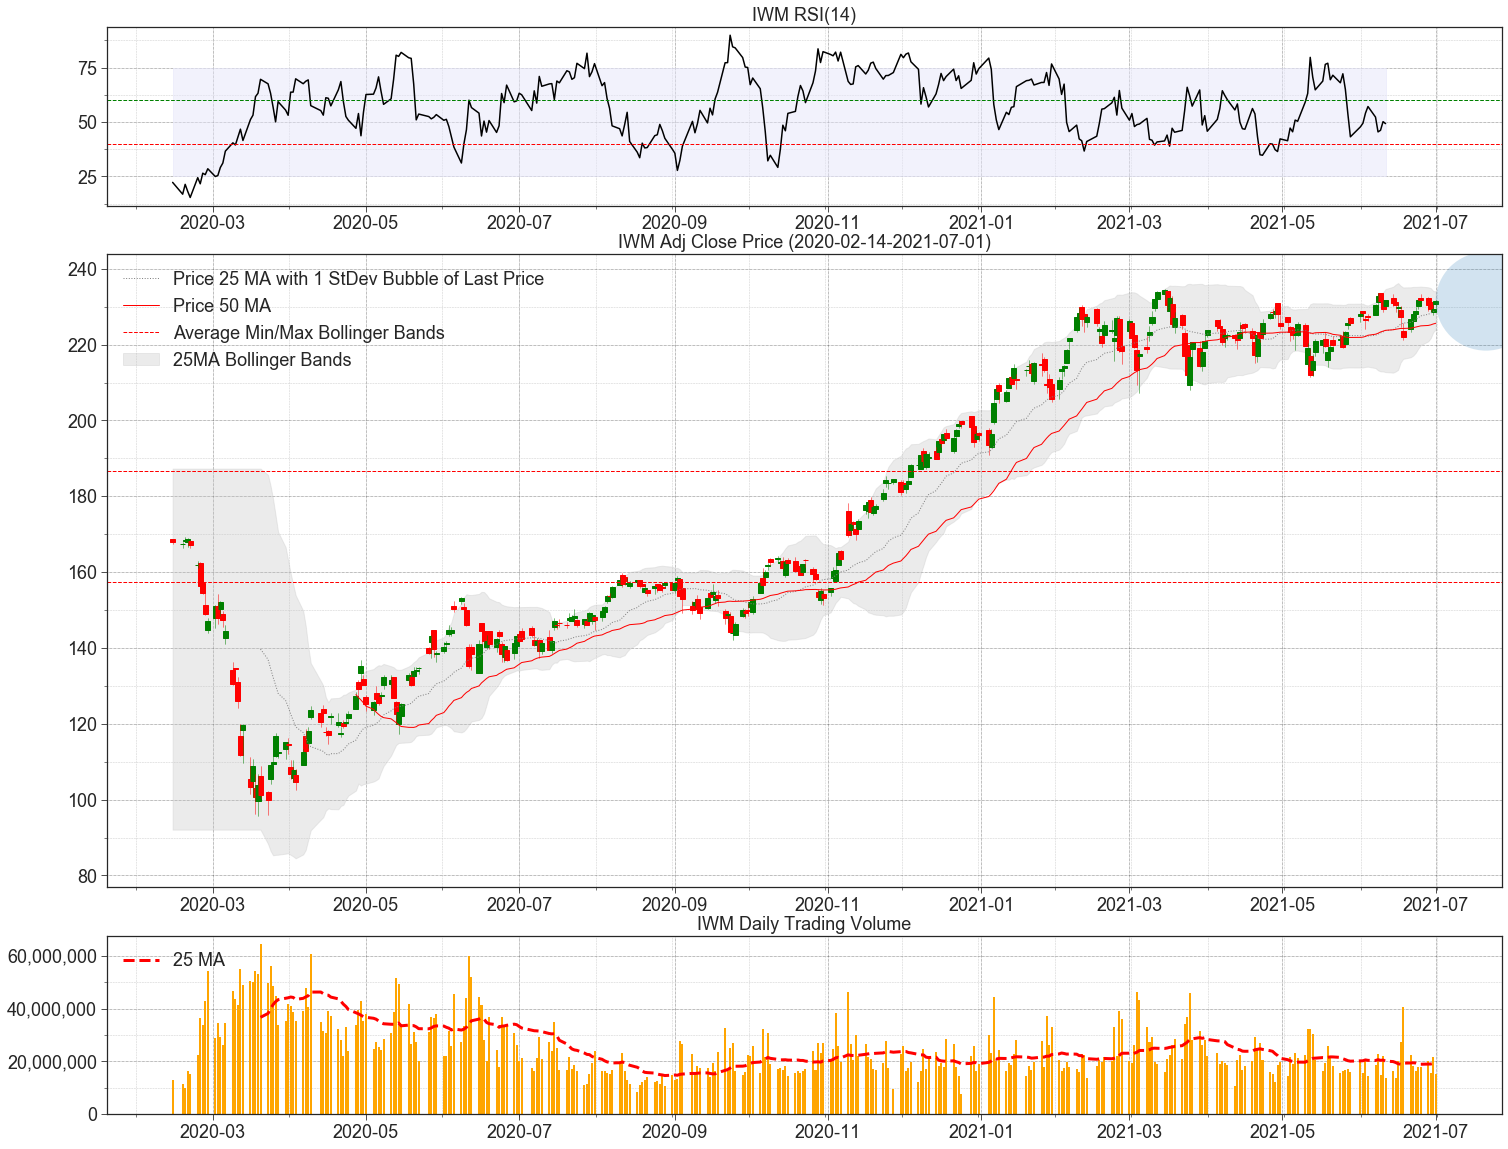

In [7]:
pl1.plotUnderlyingStudy(symbol,dt_start,dt_end,prices,sigma=prange_sigma)

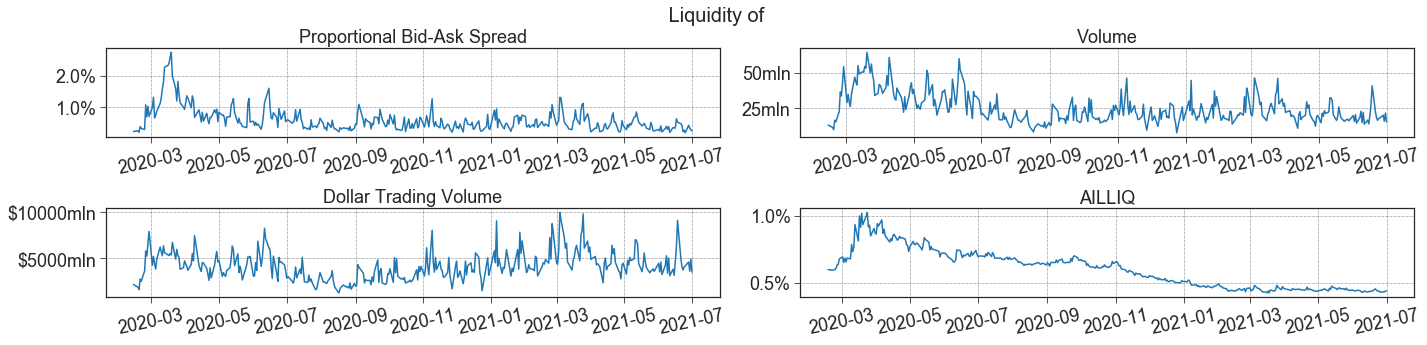

Stock Liquidity Measures
                                          Mean             Median
Proportional Bid-Ask Spread             0.0059             0.0048
Volume                         25,042,036.4080    21,951,894.0000
Dollar Trading Volume       4,211,456,264.5789 4,077,286,425.4050
AILLIQ                                  0.0060             0.0061


In [8]:
df2=pl2.printSecurityLiqStats(prices)


In [5]:
##Long (Call/PUT) Calendar Spread 
#A Long Calendar Spread is a low-risk, directionally neutral strategy that profits 
#from the passage of time and/or an increase in implied volatility.
#Example with good delta
#Long 3-month deeper ITM call: +80 delta
#Short 1-month OTM call: -33 delta

LongShort=1
ostype='CALL'
u_price=prices.Adjusted_close[len(prices)-1]
#average volatility from cones
myvol=vols[0].mean()
print('Estimated Volatility from Cones: ',myvol)

Estimated Volatility from Cones:  0.327790652534538


In [6]:
if orats==False:
    #IEXCloud data
    #datafarm1.getAllOptionChainIEX.clear_cache()
    options=datafarm1.getAllOptionChainIEX(symbol,iRate,myvol)
else:
    #ORATS historical data
    #options=datafarm2.getOptionsOrats2(dt_start,dt_end,symbol,True)
    #ORATS data at the selected date
    #datafarm2.getOptionsOrats.clear_cache()
    #options=datafarm2.getOptionsOrats(dt_end,symbol,True)
    #options=datafarm2.getOptionsOrats('2019-12-12','IWM',ddate2='2020-12-17',greeks=True)
    options=datafarm2.getOptionsOrats(dt_start,symbol,ddate2=eval_data,greeks=True)
    

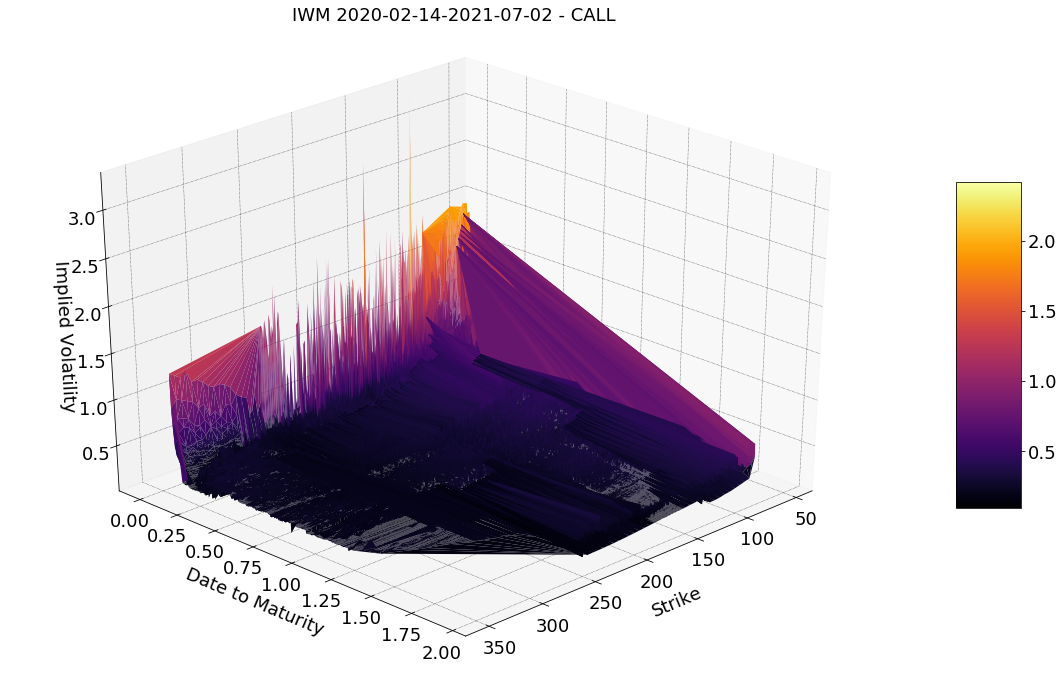

In [7]:
maxdate,void=tls.getDates(offset=+360,today_date=eval_data)
ret=pl2.plot3DVol(options,maxdate=maxdate,otype=ostype,desc=desc,fs=(20,12)) 

In [8]:
iSVol,iVol,optionsATM=pl2.compute30DVol(options,ostype,dt_start,dt_end,u_price)
pl2.plotVolConesSV(symbol,dt_start,eval_data,iVol,options,prices)

Options IVol Stats (see note in graph, if present)
                             Values
Min 52W Implied Vol (%)       26.99
Max 52W Implied Vol (%)       44.76
Last Implied Vol (%)          34.44
IV Rank (over 252 days)       41.93
IV Perc (over 252 days) (%)   32.39
Current Price                231.39
Estimated Mean iVol (%)       35.76
Min Expected Price 30-Days   219.53
Max Expected Price 30-Days   243.25


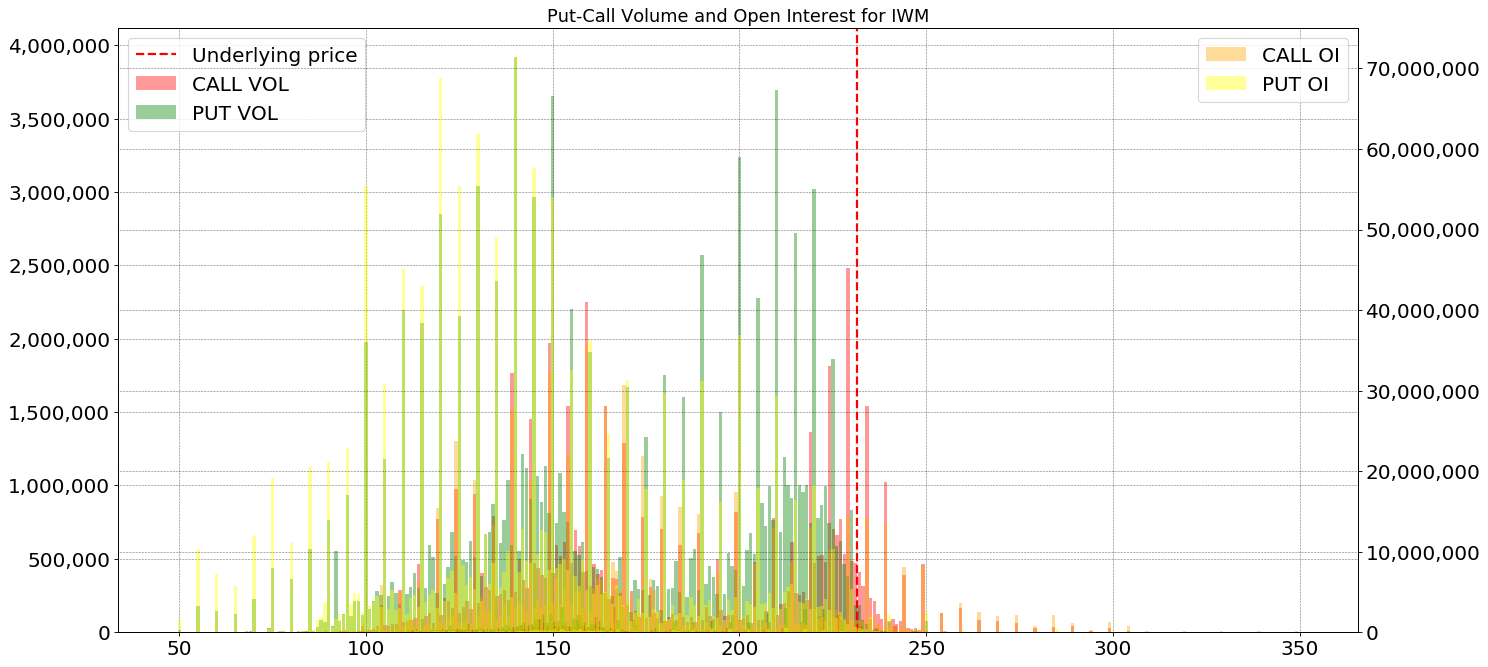

In [9]:
pl2.plotPCRatio(symbol, options,pcr_type='PCR_EQUITY')
pl2.plotPCVolOI(symbol, options,u_price)

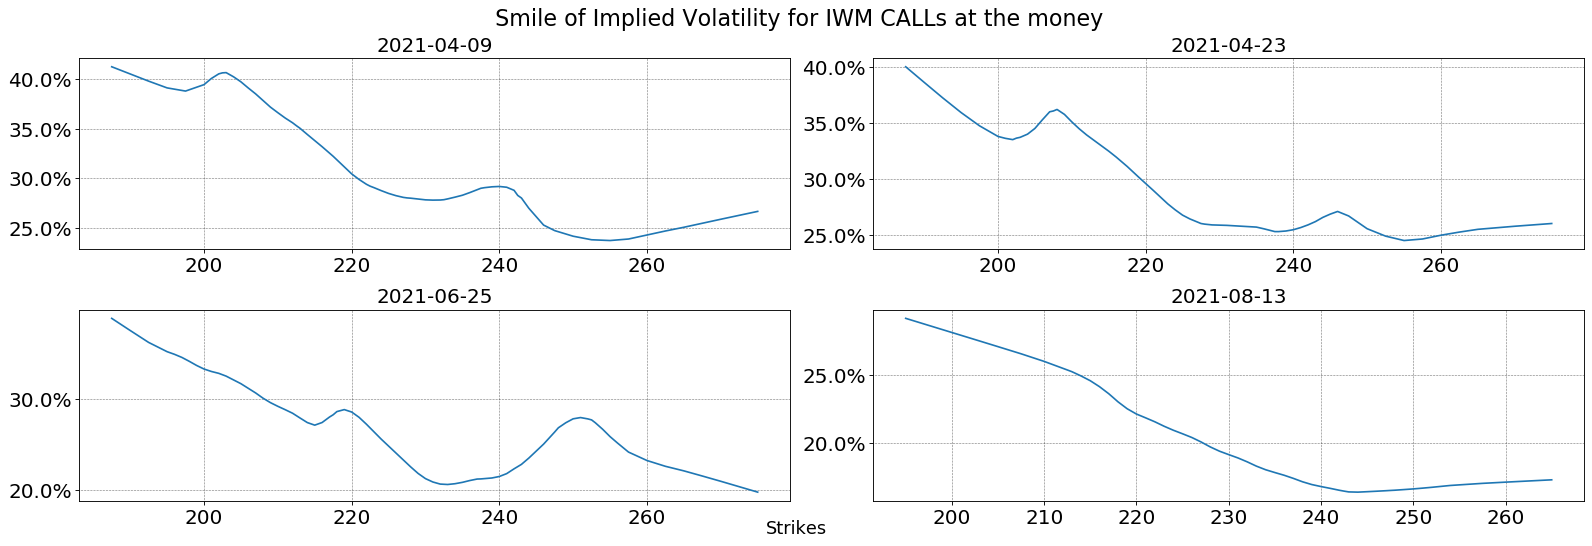

                        Values
Price                   231.39
Mean IV 2021-04-09 (%)   26.90
Mean IV 2021-04-23 (%)   29.24
Mean IV 2021-06-25 (%)   31.34
Mean IV 2021-08-13 (%)   20.30


In [10]:
expdata=['2021-04-09','2021-04-23','2021-06-25','2021-08-13']
pl2.plotSmileEATM(ostype, options, symbol,  expdata,u_price,interp=True)


In [7]:
fbo,co=o.getExpDCalSpread(ostype,eval_data,u_price,options,prange=0.50)
fbo.head(20)


EDate1     EDate2
0 2021-08-06 2021-10-15
1 2021-08-06 2021-11-19

CALLs Liquidity Measures - Mean/Median


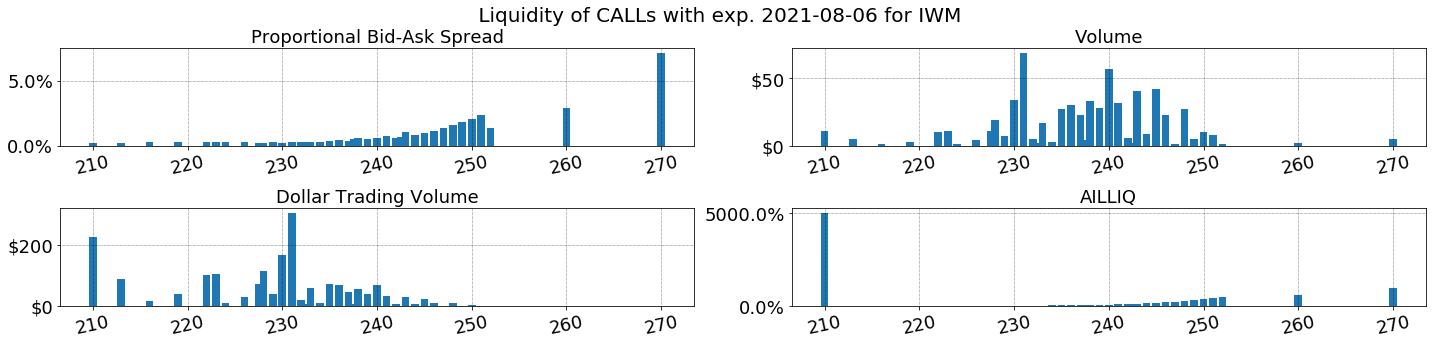

                                Mean  Median
Proportional Bid-Ask Spread   0.0158  0.0044
Volume                      361.8794 11.0000
Dollar Trading Volume       559.9567 40.0850
AILLIQ                        3.1902  0.2409
CALLs Liquidity Measures - Mean/Median


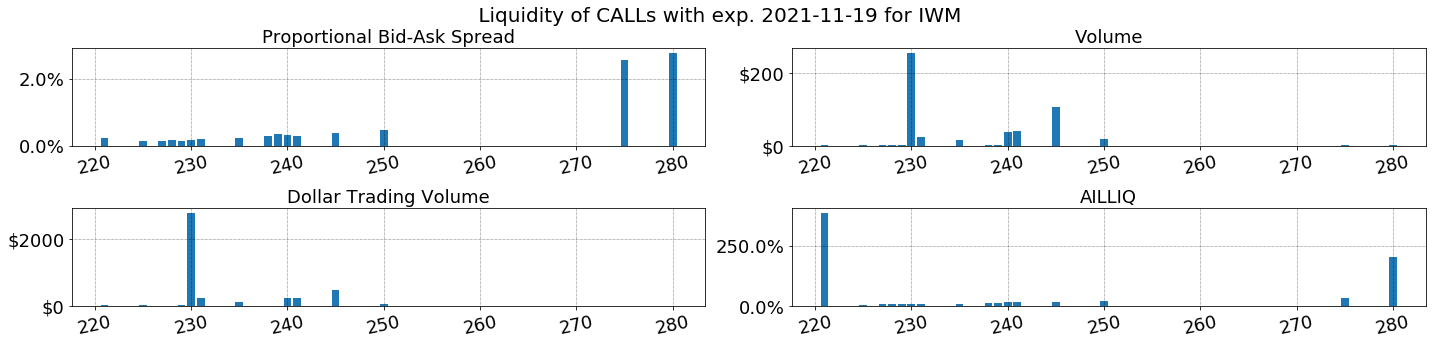

                                Mean  Median
Proportional Bid-Ask Spread   0.0158  0.0044
Volume                      361.8794 11.0000
Dollar Trading Volume       559.9567 40.0850
AILLIQ                        3.1902  0.2409


In [8]:
Expiration_N=1
d1=str(fbo.iloc[Expiration_N][0].date())
d2=str(fbo.iloc[Expiration_N][1].date())
df1=pl2.printOptLiqStats(options[options.index==eval_data],ostype,symbol,d1)
df1=pl2.printOptLiqStats(options[options.index==eval_data],ostype,symbol,d2)

In [9]:
fb=o.getCalSpreads(Expiration_N,co,fbo)
fb

expirationDate_x type_x  strike_x  lastPrice_x  impliedVolatility_x  dte_x  \
0        2021-08-06   CALL  135.0000      94.3600               0.3790 0.0959   
1        2021-08-06   CALL  140.0000      89.3600               0.3584 0.0959   
2        2021-08-06   CALL  145.0000      84.3600               0.3382 0.0959   
3        2021-08-06   CALL  150.0000      79.3600               0.3179 0.0959   
4        2021-08-06   CALL  155.0000      74.3600               0.3005 0.0959   
..              ...    ...       ...          ...                  ...    ...   
67       2021-08-06   CALL  270.0000       0.0300               0.2134 0.0959   
68       2021-08-06   CALL  275.0000       0.0300               0.2256 0.0959   
69       2021-08-06   CALL  280.0000       0.0200               0.2326 0.0959   
70       2021-08-06   CALL  285.0000       0.0000               0.1213 0.0959   
71       2021-08-06   CALL  290.0000       0.0000               0.1299 0.0959   

   expirationDate_y type_y  strike_y  lastPrice_y  ...  delta_x  gamma_x  \
0        2021-11-19   CALL  135.0000      94.5700  ...   1.0000   0.0000   
1        2021-11-19   CALL  140.0000      89.6200  ...   1.0000   0.0000   
2        2021-11-19   CALL  145.0000      84.7000  ...   1.0000   0.0000   
3        2021-11-19   CALL  150.0000      79.7900  ...   1.0000   0.0000   
4        2021-11-19   CALL  155.0000      74.9000  ...   1.0000   0.0000   
..              ...    ...       ...          ...  ...      ...      ...   
67       2021-11-19   CALL  270.0000       0.6800  ...   0.0026   0.0006   
68       2021-11-19   CALL  275.0000       0.4900  ...   0.0009   0.0002   
69       2021-11-19   CALL  280.0000       0.3600  ...   0.0003   0.0001   
70       2021-11-19   CALL  285.0000       0.2700  ...   0.0001   0.0000   
71       2021-11-19   CALL  290.0000       0.2100  ...   0.0000   0.0000   

    theta_x  vega_x  rho_x  delta_y  gamma_y  theta_y  vega_y  rho_y  
0    0.0000  0.0000 0.0000   0.9865   0.0008  -0.0057  0.0479 0.1476  
1    0.0000  0.0000 0.0000   0.9814   0.0010  -0.0076  0.0641 0.1790  
2    0.0000  0.0000 0.0000   0.9753   0.0012  -0.0098  0.0830 0.2118  
3    0.0000  0.0000 0.0000   0.9686   0.0014  -0.0119  0.0981 0.2394  
4    0.0000  0.0000 0.0000   0.9605   0.0017  -0.0143  0.1109 0.2671  
..      ...     ...    ...      ...      ...      ...     ...    ...  
67  -0.0016  0.0068 0.0006   0.0706   0.0054  -0.0118  0.1803 0.0564  
68  -0.0006  0.0021 0.0002   0.0525   0.0042  -0.0095  0.1534 0.0422  
69  -0.0002  0.0008 0.0001   0.0387   0.0033  -0.0075  0.1299 0.0312  
70  -0.0001  0.0003 0.0000   0.0287   0.0025  -0.0059  0.0902 0.0234  
71  -0.0000  0.0001 0.0000   0.0210   0.0019  -0.0046  0.0743 0.0171  

[72 rows x 22 columns]

In [10]:
sLegs=o.getCSLegs(30,fb)

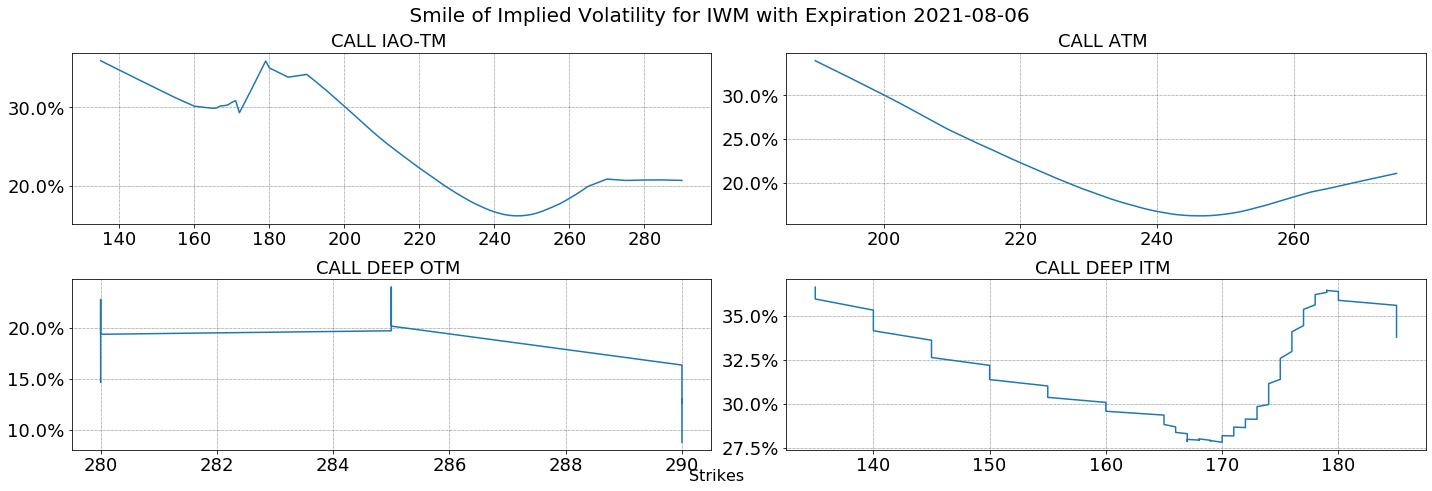

                      Values
Price                 231.39
Mean IV Deep OTM (%)   18.95
Mean IV ATM (%)        20.60
Mean IV IAO-TM (%)     22.23
Mean IV Deep ITM (%)   31.78


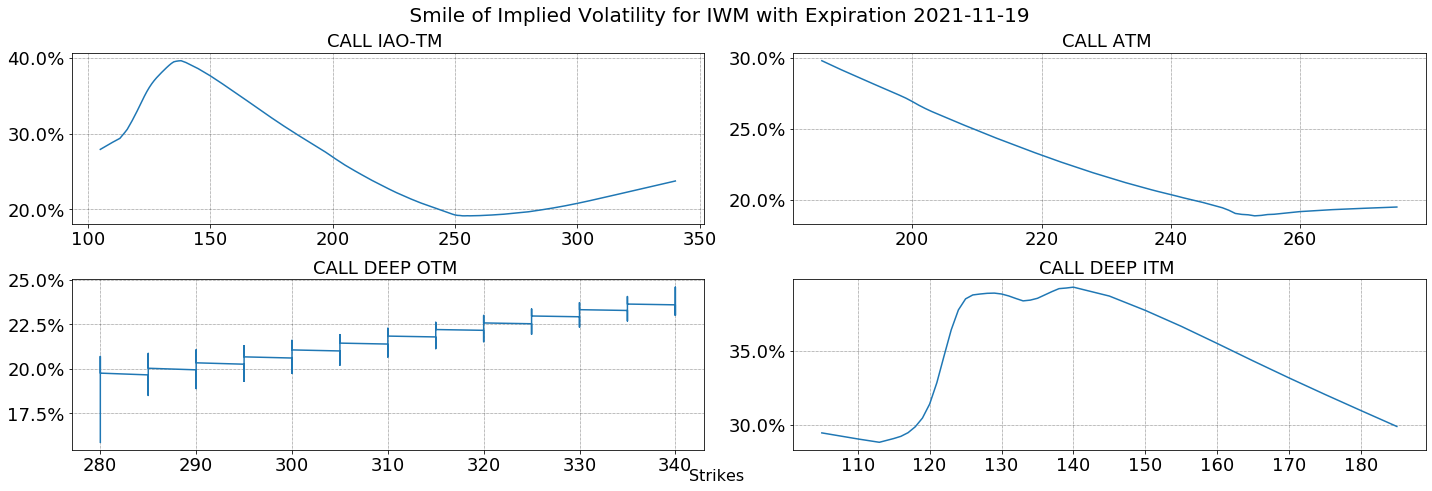

                      Values
Price                 231.39
Mean IV Deep OTM (%)   21.53
Mean IV ATM (%)        23.64
Mean IV IAO-TM (%)     27.20
Mean IV Deep ITM (%)   34.95


In [13]:
pl2.plotSmile(ostype, options, symbol, 
              fb['expirationDate_x'].iloc[0].strftime("%Y-%m-%d"),
              u_price,interp=True)
pl2.plotSmile(ostype, options, symbol, 
              fb['expirationDate_y'].iloc[0].strftime("%Y-%m-%d"),
              u_price,interp=True)

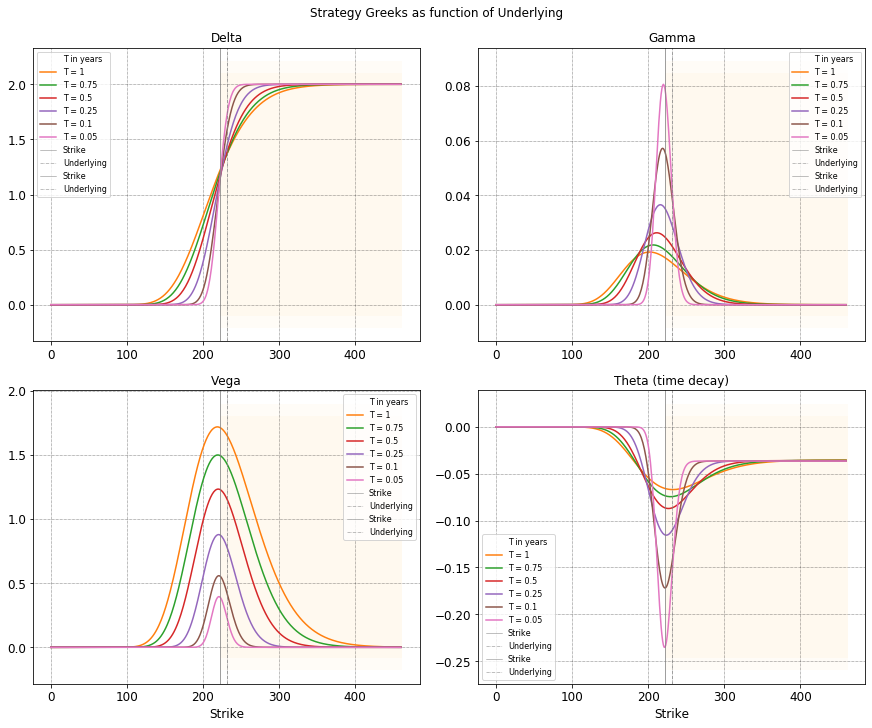

In [14]:
opts_list=o.getCSLegs2(30,fb,sigma=0.2,ir=0.03)
opt.plotGreeks2(int(u_price), opts_list,title='Strategy Greeks as function of Underlying',fs=(12,10))

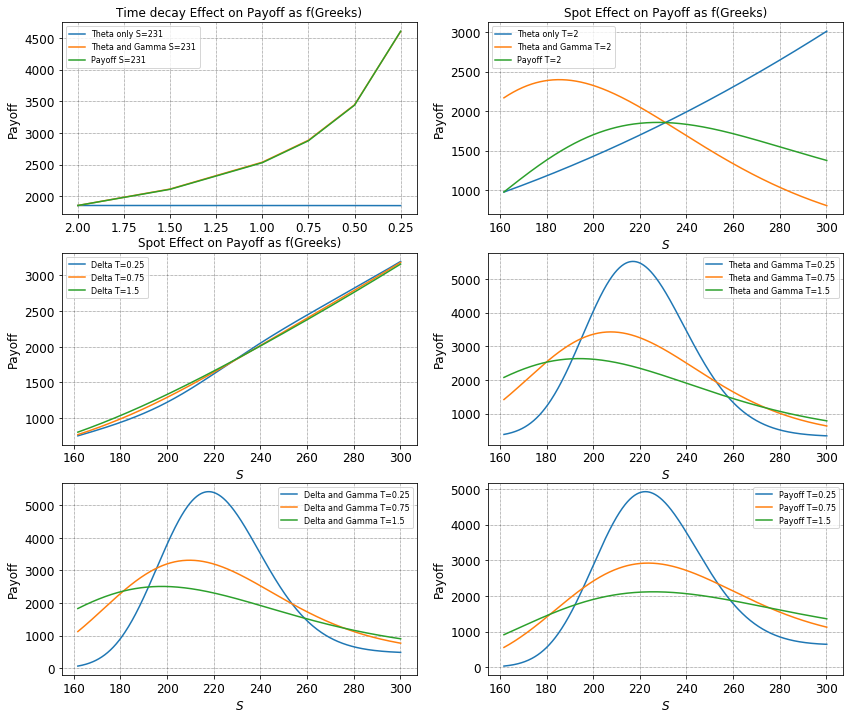

In [15]:
opt.plotGreeksPayoff2(int(u_price), opts_list, LongShort=1, r=0.03, prange=[0.30,0.30],step=0.25,fs=(14,12))


In [11]:
opt.makeDGHTable(o.getCSLegs3(30,fb, int(u_price), ir=0.03), prange=int(u_price*(myvol**2))/2)


Hedging requires  -0.4618 units of underlying
Hedging requires  1.8068 units of another derivative and  84.7107 cash


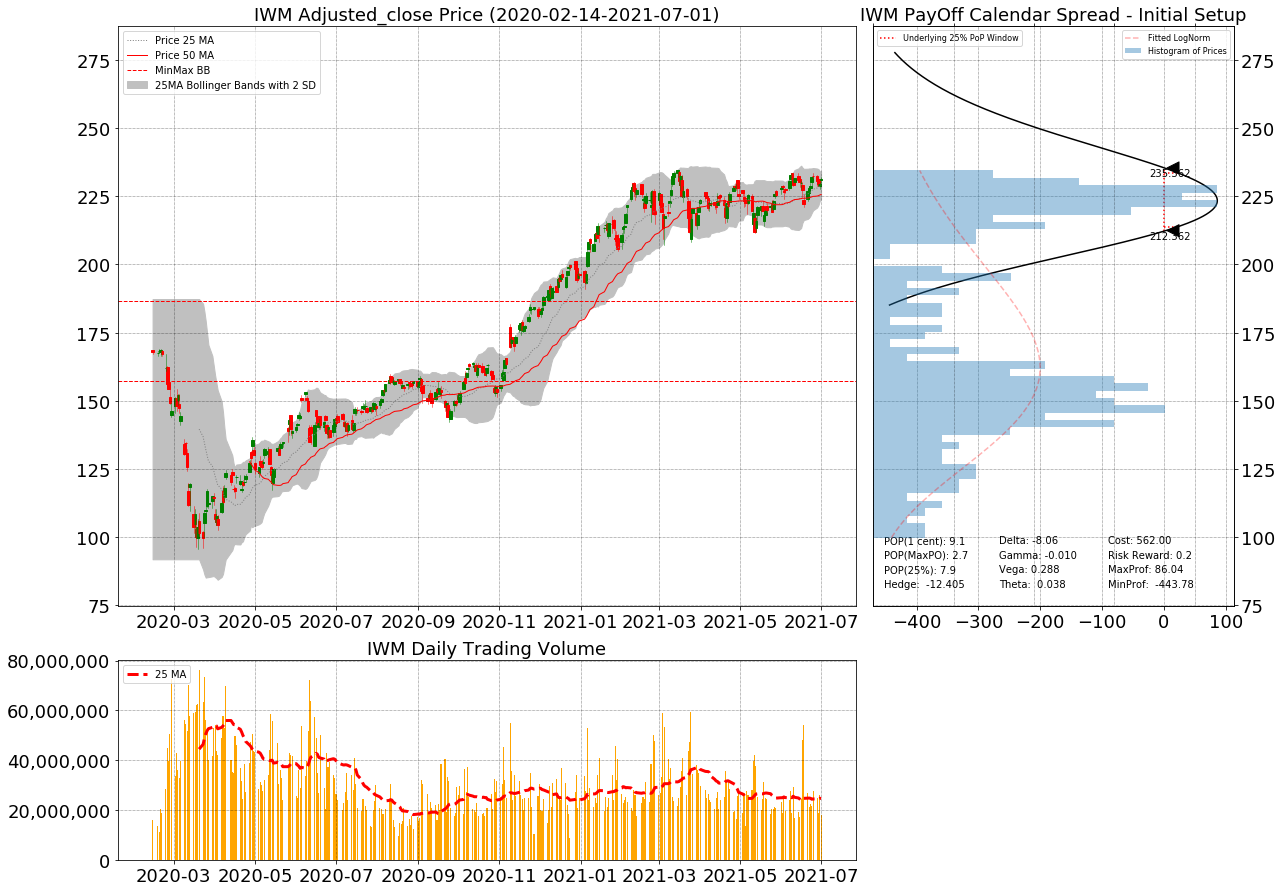

In [17]:
r1=o.calendarSpread(sLegs,u_price,iRate,desc,0.2,LongShort) #,greeks=True
clear_output(wait=True)
desc='Calendar Spread - Initial Setup'
pl1.plotUnderlyingStudy2(symbol, dt_start, dt_end, prices,r1,desc,prb=0.25)

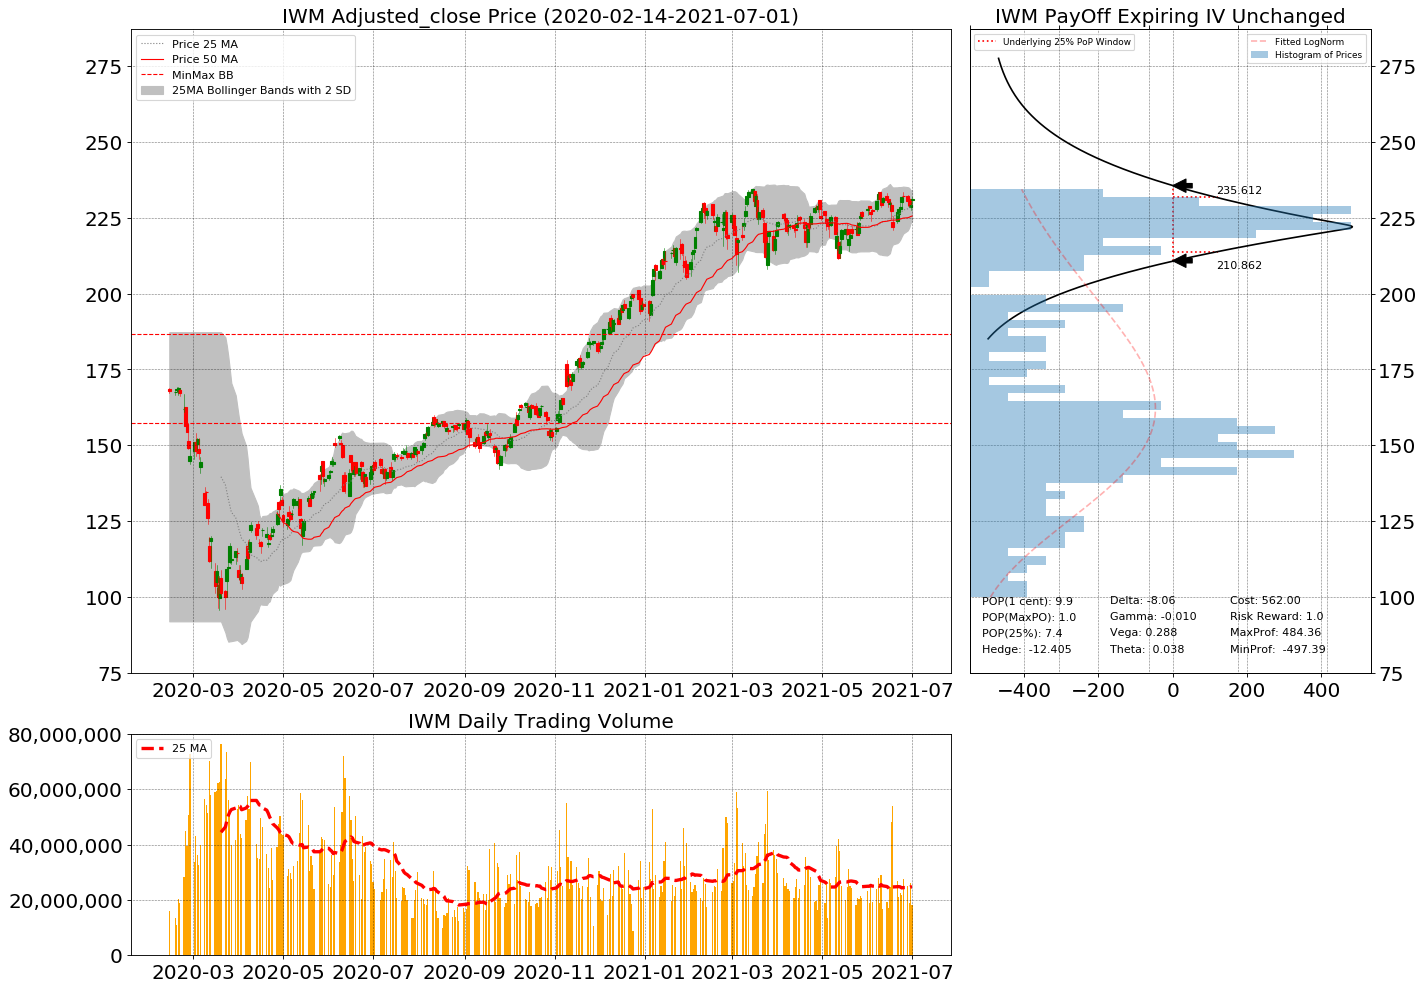

In [20]:
psLegs=sLegs
psLegs[3],psLegs[12]=0.0001,(sLegs[12]-(sLegs[3]-0.0001))

desc='Expiring IV Unchanged'
r2=o.calendarSpread(psLegs,u_price,iRate,desc,0.2,LongShort)
clear_output(wait=True)
pl1.plotUnderlyingStudy2(symbol, dt_start, dt_end, prices,r2,desc,prb=0.25)

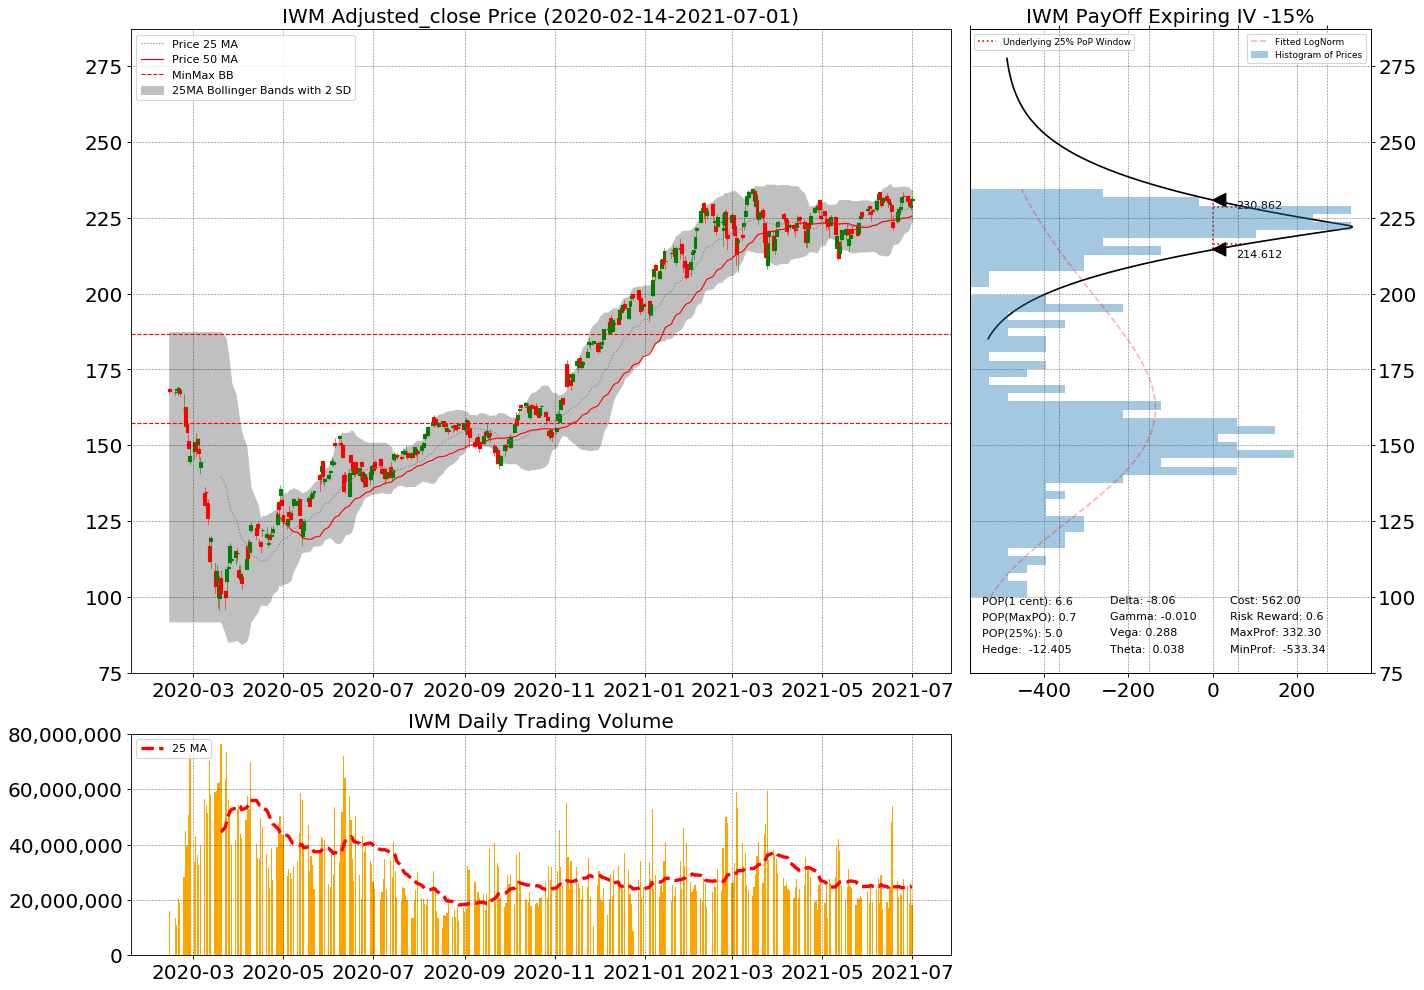

In [21]:
psLegs[2],psLegs[11]=sLegs[2]*(0.85),sLegs[11]*(0.85)

desc='Expiring IV -15%'
r3=o.calendarSpread(psLegs,u_price,iRate,desc,0.2,LongShort)
clear_output(wait=True)
pl1.plotUnderlyingStudy2(symbol, dt_start, dt_end, prices,r3,desc,prb=0.25)

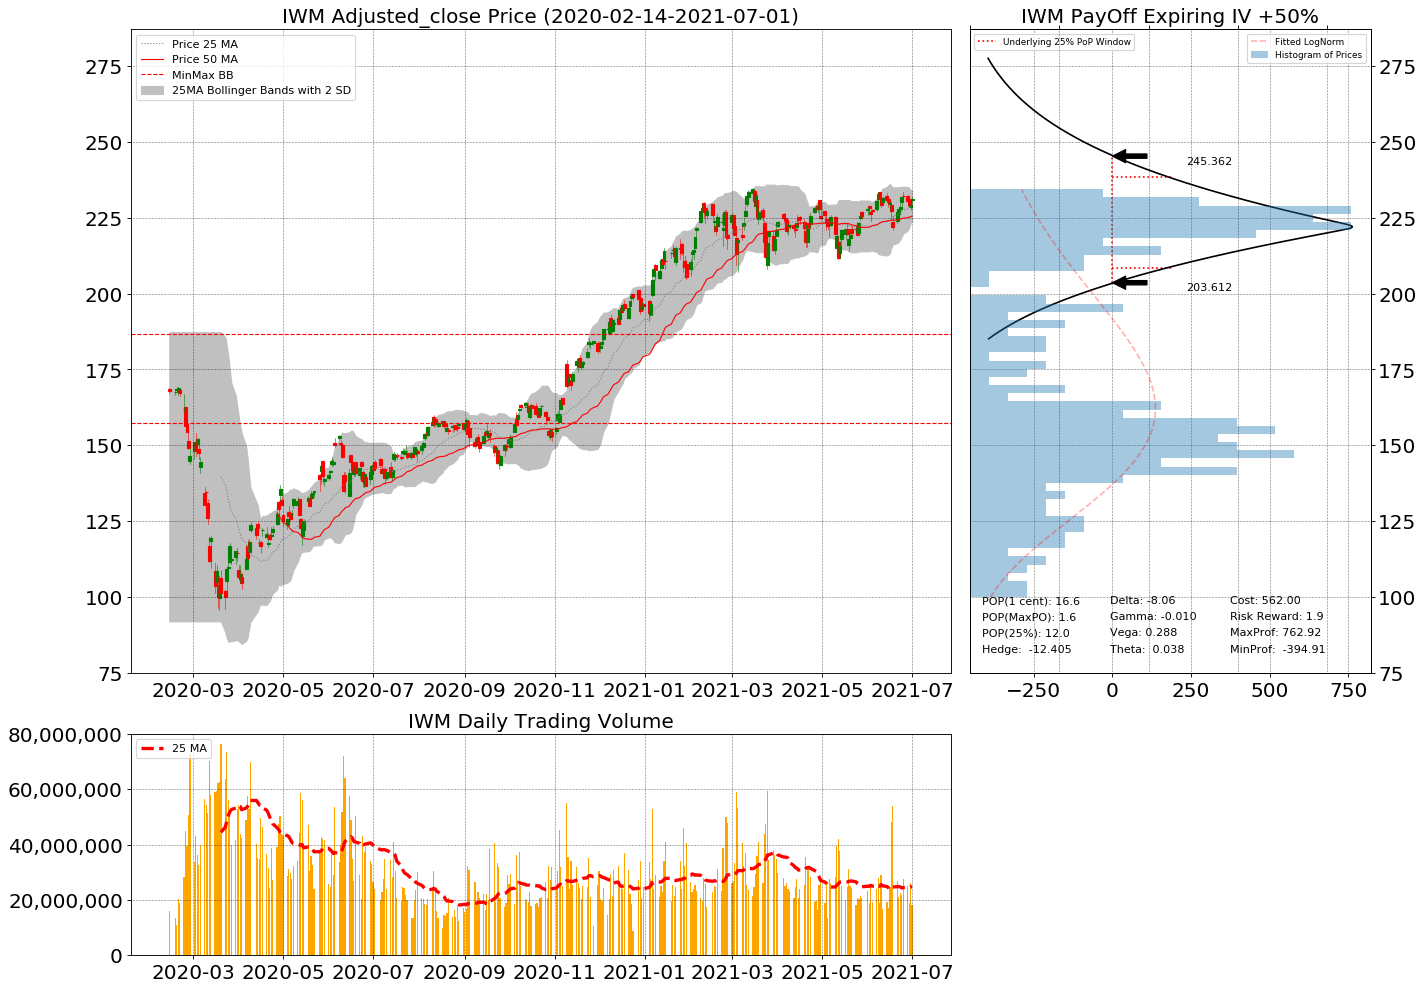

In [22]:
psLegs[2],psLegs[11]=sLegs[2]*(1.5),sLegs[11]*(1.5)

desc='Expiring IV +50%'
r4=o.calendarSpread(psLegs,u_price,iRate,desc,0.2,LongShort)
clear_output(wait=True)
pl1.plotUnderlyingStudy2(symbol, dt_start, dt_end, prices,r4,desc,prb=0.25)